# Benchmark - 2019 December 15

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns

from src.dataset import OzeDataset
from src.Benchmark import LSTM

In [2]:
# Training parameters
DATASET_PATH = 'dataset_large.npz'
BATCH_SIZE = 4
NUM_WORKERS = 4
LR = 3e-3
EPOCHS = 20
TIME_CHUNK = True

# Model parameters
K = 672 # Time window length
d_model = 48 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 4 # Number of heads
N = 4 # Number of encoder and decoder to stack
pe = None # Positional encoding

d_input = 37 # From dataset
d_output = 8 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


## Load dataset

In [3]:
dataloader = DataLoader(OzeDataset(DATASET_PATH),
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS
                       )

## Load network

In [4]:
# Load transformer with Adam optimizer and MSE loss function
net = LSTM(d_input, d_model, d_output, N).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()

## Train

[Epoch  20/20]: 100%|██████████| 7500/7500 [00:16<00:00, 456.07it/s, loss=0.00488]


Loss: 0.004880


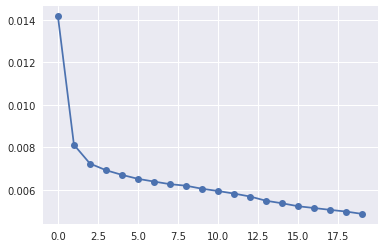

In [5]:
# Prepare loss history
hist_loss = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(netout, y.to(device))

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
    hist_loss[idx_epoch] = running_loss/len(dataloader)
plt.plot(hist_loss, 'o-')
print(f"Loss: {float(hist_loss[-1]):5f}")

## Plot results sample

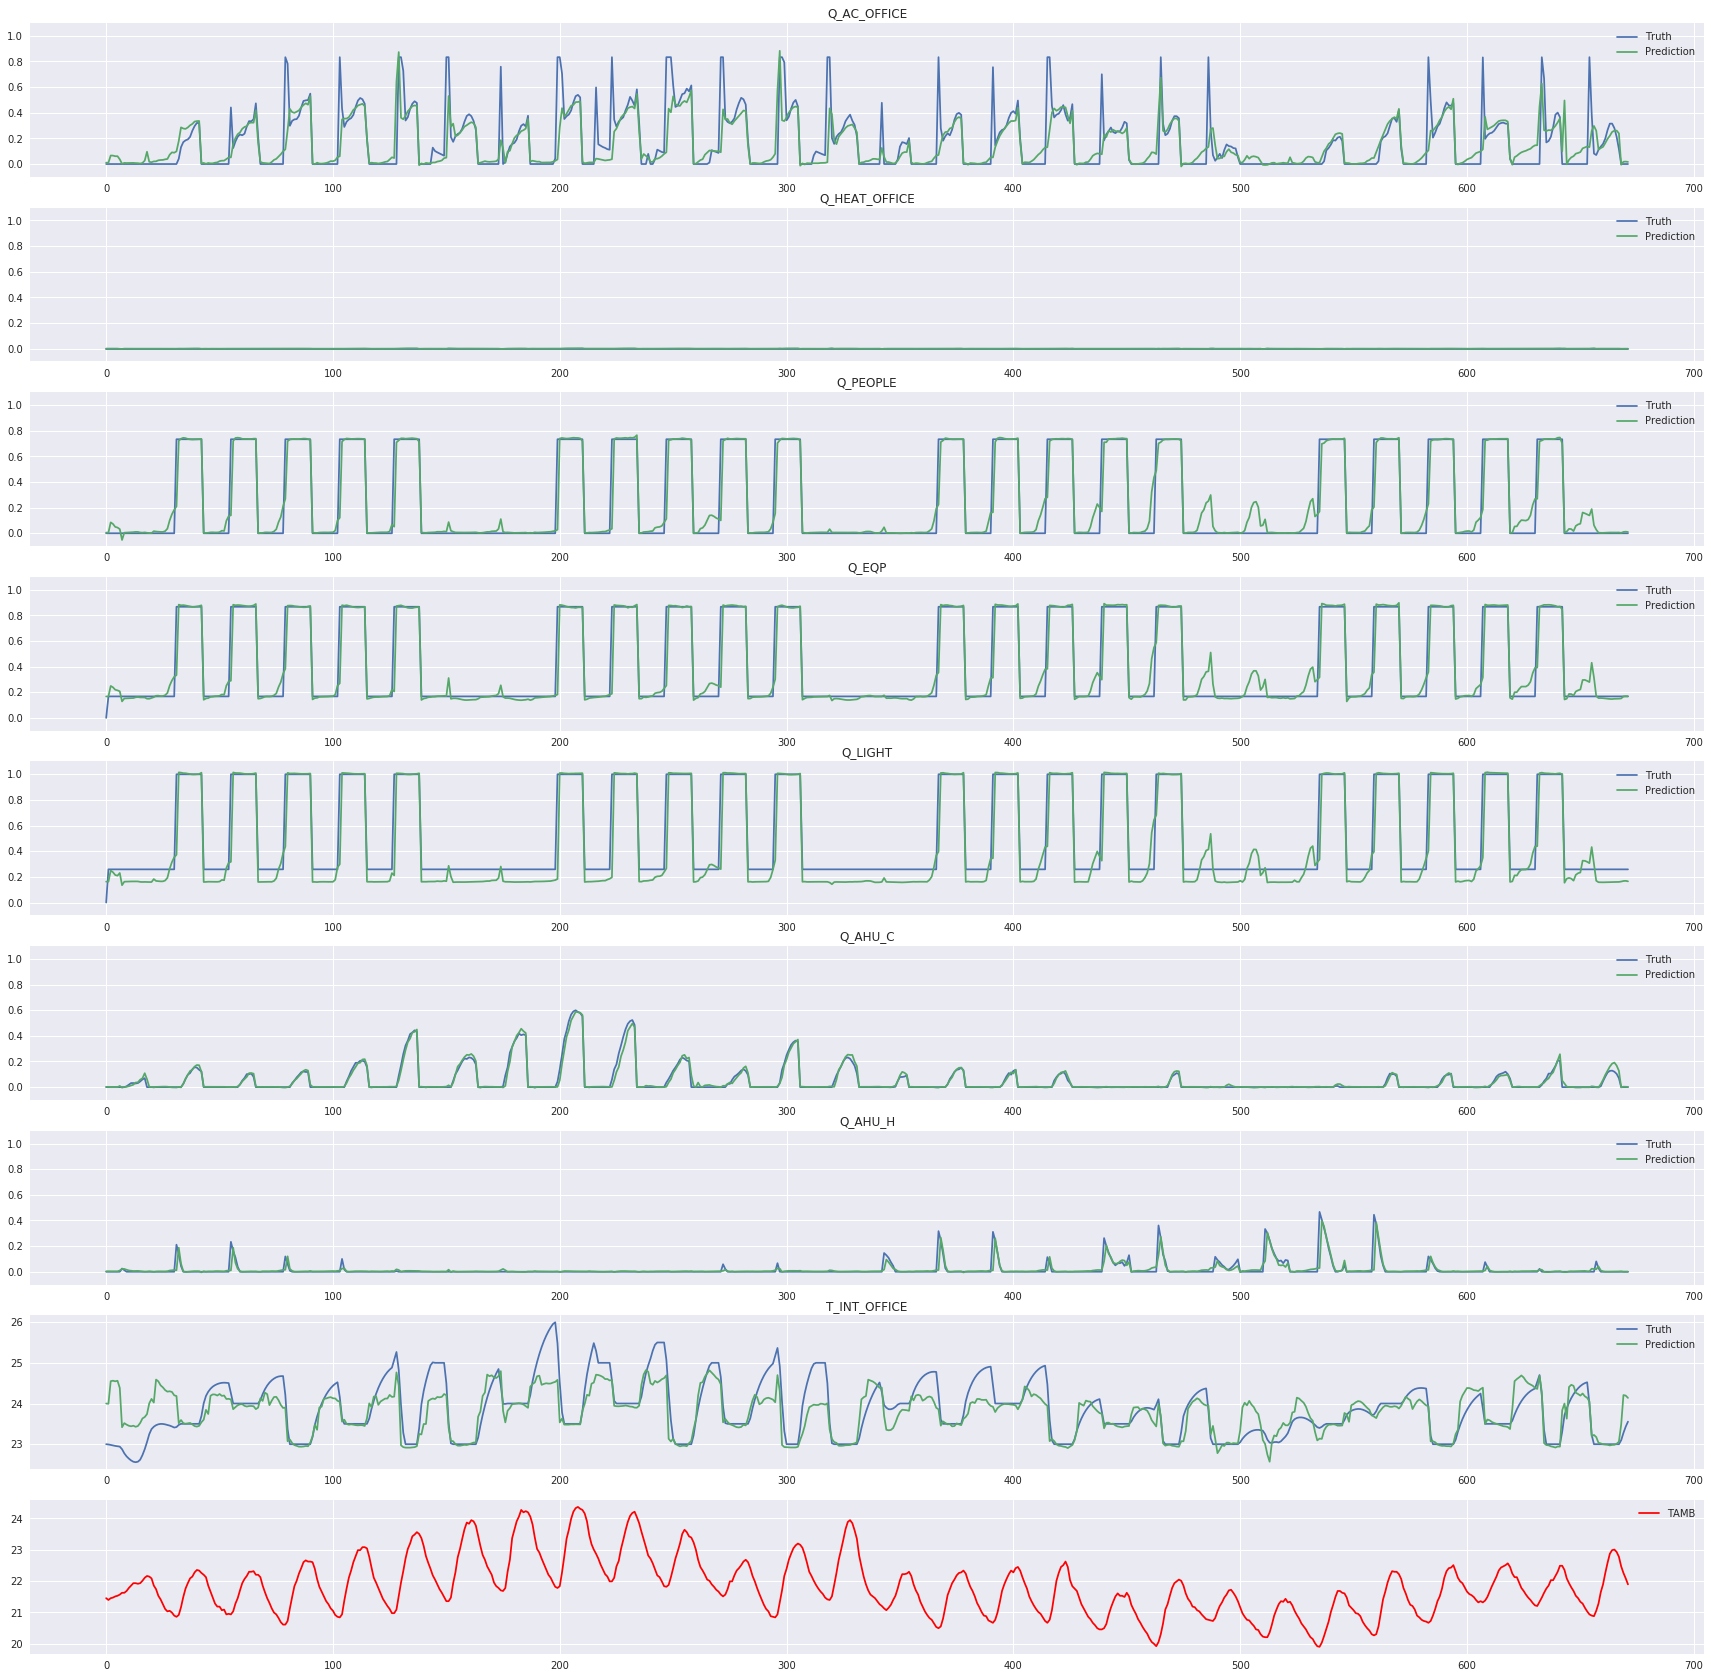

In [6]:
# Select training example
idx = np.random.randint(0, len(dataloader.dataset))
x, y = dataloader.dataset[idx]

# Run predictions
with torch.no_grad():
    netout = net(torch.Tensor(x[np.newaxis, ...]).to(device)).cpu()

plt.figure(figsize=(30, 30))
for idx_label, label in enumerate(dataloader.dataset.labels['X']):
    # Select real temperature
    y_true = y[:, idx_label]
    y_pred = netout[0, :, idx_label].numpy()
    

    plt.subplot(9, 1, idx_label+1)
    

    
    # If consumption, rescale axis
    if label.startswith('Q_'):
        plt.ylim(-0.1, 1.1)
    elif label == 'T_INT_OFFICE':
        y_true = dataloader.dataset.rescale(y_true, idx_label)
        y_pred = dataloader.dataset.rescale(y_pred, idx_label)
        
    plt.plot(y_true, label="Truth")
    plt.plot(y_pred, label="Prediction")
    plt.title(label)
    plt.legend()
    

# Plot ambient temperature
plt.subplot(9, 1, idx_label+2)
t_amb = x[:, dataloader.dataset.labels["Z"].index("TAMB")]
t_amb = dataloader.dataset.rescale(t_amb, -1)
plt.plot(t_amb, label="TAMB", c="red")
plt.legend()

plt.savefig("fig.jpg")